# Fire Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import keras
from keras import layers, optimizers
from keras import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report

import glob
from PIL import Image

Using TensorFlow backend.


In [ ]:
! unzip fire_class_images.zip

In [8]:
df_fire = pd.read_csv('fire_class_names.csv')
df_fire['label'] = df_fire['label'].apply(lambda x: 'fire' if x == 0 else 'normal')
df_fire

,Unnamed: 0,Unnamed: 0.1,filename,label
0,0,0.0,92983122.jpg,normal
1,1,1.0,wildfire-coverage-521x308.jpg,normal
2,2,2.0,201307-restroom-fire-safety-fire1.jpg,normal
3,3,3.0,X-Files_Office_on_fire.jpg,normal
4,4,4.0,tree-fire.jpg,normal
...,...,...,...,...
1029,382,NaN,fire.646.png,normal
1030,383,NaN,fire.536.png,normal
1031,384,NaN,fire.665.png,normal
1032,385,NaN,fire.88.png,normal


### Data Preperation

In [9]:
df_train, df_test, y_train, y_test = model_selection.train_test_split(df_fire.drop(columns=['label']), df_fire['label'], stratify=df_fire['label'], random_state=0)
df_train['label'] = pd.Series((y for y in y_train), index=df_train.index)
df_test['label'] = pd.Series((y for y in y_test), index=df_test.index)

In [28]:
train_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, directory='fire_class_images/', x_col='filename',
     y_col='label', batch_size=30, class_mode='binary')
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test, directory='fire_class_images/', x_col='filename',
     y_col='label', batch_size=30, class_mode='binary')

Found 775 validated image filenames belonging to 2 classes.
Found 259 validated image filenames belonging to 2 classes.


### Baseline Model And Model Accuracy

In [29]:
from keras import metrics

def define_baseline_fire():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
	      layers.Dense(1, activation='sigmoid'),
    ])

    opt = optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train model and get it's history
print('Training Model')
baseline_fire = define_baseline_fire()
history = baseline_fire.fit(train_generator, steps_per_epoch=len(df_train)//30, epochs=10)

Training Model
Epoch 1/10
25/25 [==============================] - 23s 938ms/step - loss: 9.5743 - accuracy: 0.6617
Epoch 2/10
25/25 [==============================] - 24s 952ms/step - loss: 1.7851 - accuracy: 0.7879
Epoch 3/10
25/25 [==============================] - 23s 924ms/step - loss: 0.8340 - accuracy: 0.8201
Epoch 4/10
25/25 [==============================] - 24s 956ms/step - loss: 0.8543 - accuracy: 0.8240
Epoch 5/10
25/25 [==============================] - 22s 879ms/step - loss: 1.2354 - accuracy: 0.8041
Epoch 6/10
25/25 [==============================] - 23s 916ms/step - loss: 1.0171 - accuracy: 0.8094
Epoch 7/10
25/25 [==============================] - 23s 919ms/step - loss: 0.6396 - accuracy: 0.8819
Epoch 8/10
25/25 [==============================] - 24s 971ms/step - loss: 0.5432 - accuracy: 0.8631
Epoch 9/10
25/25 [==============================] - 22s 887ms/step - loss: 0.6415 - accuracy: 0.8483
Epoch 10/10
25/25 [==============================] - 23s 917ms/step - loss: 

In [30]:
# Evaluate model
print('Evaluating Model')
_, acc = baseline_fire.evaluate(test_generator, steps=len(df_test)//30, verbose=0)
print('Train Accuracy: %.3f' % (acc * 100.0))

Evaluating Model
Train Accuracy: 81.667


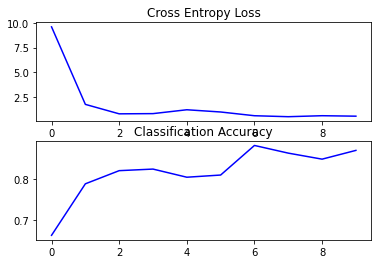

In [31]:
def summarize_diagnostics(history):
    # Plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    # plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # Plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    # plt.plot(history.history['val_accuracy'], color='orange', label='test')
    
summarize_diagnostics(history)

## CNN Model and Model Accuracy

In [32]:
def define_cnn_model():
	model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
	  layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
	  layers.MaxPooling2D((2, 2)),
	  layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
	  layers.MaxPooling2D((2, 2)),
	  layers.Flatten(),
	  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
	  layers.Dense(1, activation='sigmoid')
  ])
	
	# compile model
	opt = optimizers.SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

cnn_model = define_cnn_model()
history = baseline_fire.fit(train_generator, steps_per_epoch=len(df_train)//30, epochs=10)

Epoch 1/10
25/25 [==============================] - 23s 926ms/step - loss: 0.3006 - accuracy: 0.9195
Epoch 2/10
25/25 [==============================] - 23s 910ms/step - loss: 0.1906 - accuracy: 0.9248
Epoch 3/10
25/25 [==============================] - 23s 921ms/step - loss: 0.2302 - accuracy: 0.9342
Epoch 4/10
25/25 [==============================] - 23s 906ms/step - loss: 0.1986 - accuracy: 0.9248
Epoch 5/10
25/25 [==============================] - 23s 912ms/step - loss: 0.2954 - accuracy: 0.9087
Epoch 6/10
25/25 [==============================] - 25s 1s/step - loss: 0.4545 - accuracy: 0.8733
Epoch 7/10
25/25 [==============================] - 21s 834ms/step - loss: 0.2233 - accuracy: 0.9216
Epoch 8/10
25/25 [==============================] - 25s 988ms/step - loss: 0.1789 - accuracy: 0.9396
Epoch 9/10
25/25 [==============================] - 23s 917ms/step - loss: 0.3105 - accuracy: 0.9020
Epoch 10/10
25/25 [==============================] - 22s 861ms/step - loss: 0.1673 - accuracy:

In [21]:
# Evaluate model
print('Evaluating Model')
_, acc = baseline_fire.evaluate(test_generator, steps=len(df_test)//30, verbose=0)
print('Train Accuracy: %.3f' % (acc * 100.0))

Evaluating Model
Train Accuracy: 88.333


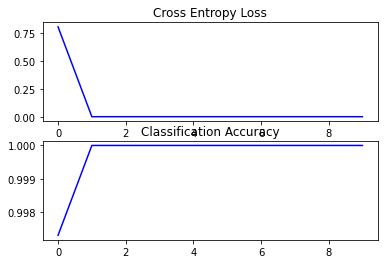

In [27]:
summarize_diagnostics(history)